<a href="https://colab.research.google.com/github/oimartin/Predicting_House_Prices/blob/main/predicting_home_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices

## Ingest

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error

# read in training data set for housing prices
train = pd.read_csv('https://raw.githubusercontent.com/oimartin/Predicting_House_Prices/main/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/oimartin/Predicting_House_Prices/main/data/test.csv')

140000    20
135000    17
145000    14
155000    14
190000    13
          ..
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, Length: 663, dtype: int64

163000.0

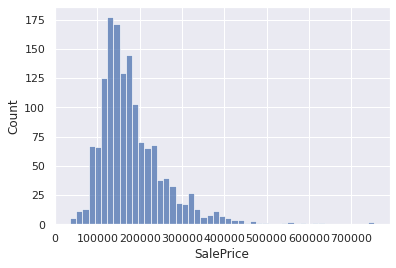

In [2]:
# Observe SalePrice train data
sns.set_theme(color_codes=True)

sns.histplot(train.SalePrice)

# Show any value counts, including NA
display(train.SalePrice.value_counts(dropna=False))
display(train.SalePrice.median())


In [3]:
# Save SalePrice train data and drop from df for independent variable preprocessing
y = train['SalePrice']
train = train.drop(columns=['SalePrice'])
display(y.describe())
display(train.info())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

In [4]:
# Observe info about test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## EDA

### Missing Values

In [5]:
# Show columns with the missing values in train set
def missing_columns (data_frame):
  missing = pd.DataFrame([data_frame.isna()[column].value_counts() 
                         for column in train.columns]).reset_index().rename(columns={'index':'Column', 0:'Present',1:'Missing'})

  top_na = missing[missing['Missing'] >= 1].sort_values(by='Missing',ascending=False)
  
  return top_na, len(top_na)

In [6]:
display(missing_columns(train)[0])
display(missing_columns(train)[1])

# Save list of missing train data
train_missing = missing_columns(train)[0]

,Column,Present,Missing
72,PoolQC,7.0,1453.0
74,MiscFeature,54.0,1406.0
6,Alley,91.0,1369.0
73,Fence,281.0,1179.0
57,FireplaceQu,770.0,690.0
3,LotFrontage,1201.0,259.0
58,GarageType,1379.0,81.0
59,GarageYrBlt,1379.0,81.0
60,GarageFinish,1379.0,81.0
63,GarageQual,1379.0,81.0


19

In [7]:
def missing_columns_graph (top_na):
  sns.set_theme(color_codes=True)

  # Create barplot of the columns with the most missing data in train set
  plt.figure(figsize=(11,10), frameon=False)
  sns.set_color_codes("pastel")
  ax = sns.barplot(x="Present", y="Column", data=top_na,
              label="Present", color="orange")

  sns.set_color_codes("muted")
  ax = sns.barplot(x="Missing", y="Column", data=top_na,
            label='Missing', color='silver')

  ax.legend()
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
  plt.xlabel('Rows')
  plt.ylabel('Data Columns with the Most NaNs')
  # ax.figure.savefig('missing_data.png')
  plt.tight_layout()
  
  return ax


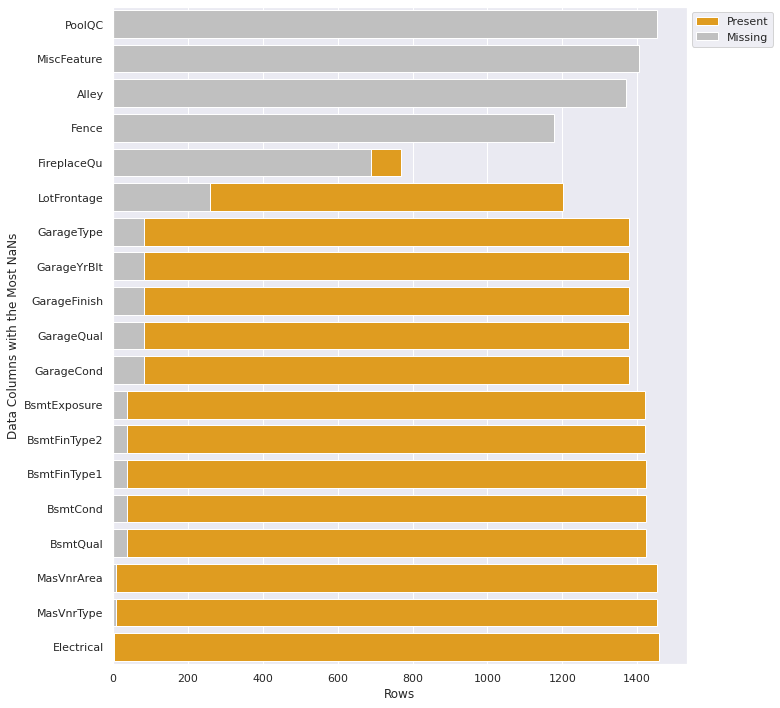

In [8]:
# Graph train missing data
missing_columns_graph(train_missing)

#### Numerical Missing Values

In [9]:
def num_missing (data_frame, missing_data):
    numerical_missing = list(data_frame[list(missing_data['Column'])].describe().columns)

    data_num_fill = pd.DataFrame()
    data_num_fill = data_frame[numerical_missing].copy()

    for feature in numerical_missing:
      data_num_fill[feature] = data_num_fill[feature].fillna(data_num_fill[feature].median())
    return data_num_fill, numerical_missing

In [10]:
train_num_miss = num_missing(train,train_missing)[1]
train[train_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   GarageYrBlt  1379 non-null   float64
 2   MasVnrArea   1452 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [11]:
df = num_missing(train,train_missing)[0]

train[train_num_miss] = df[train_num_miss]
train[train_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1460 non-null   float64
 1   GarageYrBlt  1460 non-null   float64
 2   MasVnrArea   1460 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


#### Categorical Missing Values

In [12]:
def cat_missing (all_missing_data, numerical_missing):
  categorical_missing = []
  
  for element in list(all_missing_data['Column']):
    if element not in numerical_missing:
        categorical_missing.append(element)
  return categorical_missing


In [13]:
# Observe degree of missing data from categorical columns from train dataset
train_cat_miss = cat_missing(train_missing, train_num_miss)
train[train_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        7 non-null      object
 1   MiscFeature   54 non-null     object
 2   Alley         91 non-null     object
 3   Fence         281 non-null    object
 4   FireplaceQu   770 non-null    object
 5   GarageType    1379 non-null   object
 6   GarageFinish  1379 non-null   object
 7   GarageQual    1379 non-null   object
 8   GarageCond    1379 non-null   object
 9   BsmtExposure  1422 non-null   object
 10  BsmtFinType2  1422 non-null   object
 11  BsmtFinType1  1423 non-null   object
 12  BsmtCond      1423 non-null   object
 13  BsmtQual      1423 non-null   object
 14  MasVnrType    1452 non-null   object
 15  Electrical    1459 non-null   object
dtypes: object(16)
memory usage: 182.6+ KB


In [14]:
def fill_cat_na (data_frame, categorical_missing):
  remove = ['QC', 'Qu', 'Type', 'Finish', 'Qual', 'Feature',
            'Cond', 'Exposure', 'FinType1', 'FinType2']

  cat_fill = pd.DataFrame()
  cat_fill = data_frame[categorical_missing].copy()

  for feature in categorical_missing:
    for suffix in remove:
      if feature.endswith(suffix) is True:
        shrt_feat = feature[0:-len(suffix)]
        cat_fill[feature] = cat_fill[feature].fillna(f"No_{shrt_feat}")
  
  cat_fill['Alley'] = cat_fill['Alley'].fillna('No_Alley')
  cat_fill['Fence'] = cat_fill['Fence'].fillna('No_Fence')

  for feature in categorical_missing:
    cat_fill[feature] = cat_fill[feature].fillna('Unknown')
    
  return cat_fill

In [15]:
# apply fill_cat_na to train dataset
df = fill_cat_na(train,train_cat_miss)

train[train_cat_miss] = df[train_cat_miss]
train[train_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        1460 non-null   object
 1   MiscFeature   1460 non-null   object
 2   Alley         1460 non-null   object
 3   Fence         1460 non-null   object
 4   FireplaceQu   1460 non-null   object
 5   GarageType    1460 non-null   object
 6   GarageFinish  1460 non-null   object
 7   GarageQual    1460 non-null   object
 8   GarageCond    1460 non-null   object
 9   BsmtExposure  1460 non-null   object
 10  BsmtFinType2  1460 non-null   object
 11  BsmtFinType1  1460 non-null   object
 12  BsmtCond      1460 non-null   object
 13  BsmtQual      1460 non-null   object
 14  MasVnrType    1460 non-null   object
 15  Electrical    1460 non-null   object
dtypes: object(16)
memory usage: 182.6+ KB


### Impute Test Data

In [16]:
test_missing = missing_columns(test)[0]

test_num_miss = num_missing(test,test_missing)[1]
test[test_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1232 non-null   float64
 1   GarageYrBlt   1381 non-null   float64
 2   MasVnrArea    1444 non-null   float64
 3   BsmtFullBath  1457 non-null   float64
 4   BsmtHalfBath  1457 non-null   float64
 5   GarageCars    1458 non-null   float64
 6   GarageArea    1458 non-null   float64
 7   TotalBsmtSF   1458 non-null   float64
 8   BsmtUnfSF     1458 non-null   float64
 9   BsmtFinSF2    1458 non-null   float64
 10  BsmtFinSF1    1458 non-null   float64
dtypes: float64(11)
memory usage: 125.5 KB


In [17]:
df = num_missing(test,test_missing)[0]

test[test_num_miss] = df[test_num_miss]
test[test_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1459 non-null   float64
 1   GarageYrBlt   1459 non-null   float64
 2   MasVnrArea    1459 non-null   float64
 3   BsmtFullBath  1459 non-null   float64
 4   BsmtHalfBath  1459 non-null   float64
 5   GarageCars    1459 non-null   float64
 6   GarageArea    1459 non-null   float64
 7   TotalBsmtSF   1459 non-null   float64
 8   BsmtUnfSF     1459 non-null   float64
 9   BsmtFinSF2    1459 non-null   float64
 10  BsmtFinSF1    1459 non-null   float64
dtypes: float64(11)
memory usage: 125.5 KB


In [18]:
test_cat_miss = cat_missing(test_missing, test_num_miss)
test[test_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        3 non-null      object
 1   MiscFeature   51 non-null     object
 2   Alley         107 non-null    object
 3   Fence         290 non-null    object
 4   FireplaceQu   729 non-null    object
 5   GarageCond    1381 non-null   object
 6   GarageQual    1381 non-null   object
 7   GarageFinish  1381 non-null   object
 8   GarageType    1383 non-null   object
 9   BsmtCond      1414 non-null   object
 10  BsmtExposure  1415 non-null   object
 11  BsmtQual      1415 non-null   object
 12  BsmtFinType1  1417 non-null   object
 13  BsmtFinType2  1417 non-null   object
 14  MasVnrType    1443 non-null   object
 15  MSZoning      1455 non-null   object
 16  Functional    1457 non-null   object
 17  Utilities     1457 non-null   object
 18  KitchenQual   1458 non-null   object
 19  Exteri

In [19]:
df = fill_cat_na(test,test_cat_miss)

test[test_cat_miss] = df[test_cat_miss]
test[test_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        1459 non-null   object
 1   MiscFeature   1459 non-null   object
 2   Alley         1459 non-null   object
 3   Fence         1459 non-null   object
 4   FireplaceQu   1459 non-null   object
 5   GarageCond    1459 non-null   object
 6   GarageQual    1459 non-null   object
 7   GarageFinish  1459 non-null   object
 8   GarageType    1459 non-null   object
 9   BsmtCond      1459 non-null   object
 10  BsmtExposure  1459 non-null   object
 11  BsmtQual      1459 non-null   object
 12  BsmtFinType1  1459 non-null   object
 13  BsmtFinType2  1459 non-null   object
 14  MasVnrType    1459 non-null   object
 15  MSZoning      1459 non-null   object
 16  Functional    1459 non-null   object
 17  Utilities     1459 non-null   object
 18  KitchenQual   1459 non-null   object
 19  Exteri

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Search for Features in Train Dataset

In [104]:
def mask_corr_graph (data_frame, columnsof_interest, fig_size=(7,5), show_corr=True, fig_name='feature_corr'):
  sns.set_theme(color_codes=True)

  features_corr = data_frame[columnsof_interest].corr()

  mask = np.zeros_like(features_corr)
  mask[np.triu_indices_from(mask)] = True

  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=fig_size)
    ax = sns.heatmap(features_corr, annot=show_corr, linewidths=0.5, cmap="RdYlGn", mask=mask)

  ax.figure.savefig(f"{fig_name}.png")
    
  return ax

In [22]:
# add SalePrice information and train data into new df
train_corr = pd.DataFrame()
train_corr = train.copy()
train_corr['SalePrice'] = y.copy()
train_corr

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,No_Fireplace,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,No_Pool,No_Fence,No_Misc,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No_Alley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,No_Pool,No_Fence,No_Misc,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,No_Pool,No_Fence,No_Misc,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,No_Pool,No_Fence,No_Misc,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No_Alley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,No_Pool,No_Fence,No_Misc,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,No_Pool,No_Fence,No_Misc,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,No_Pool,MnPrv,No_Misc,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,No_Pool,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,No_Alley,Reg,Lvl

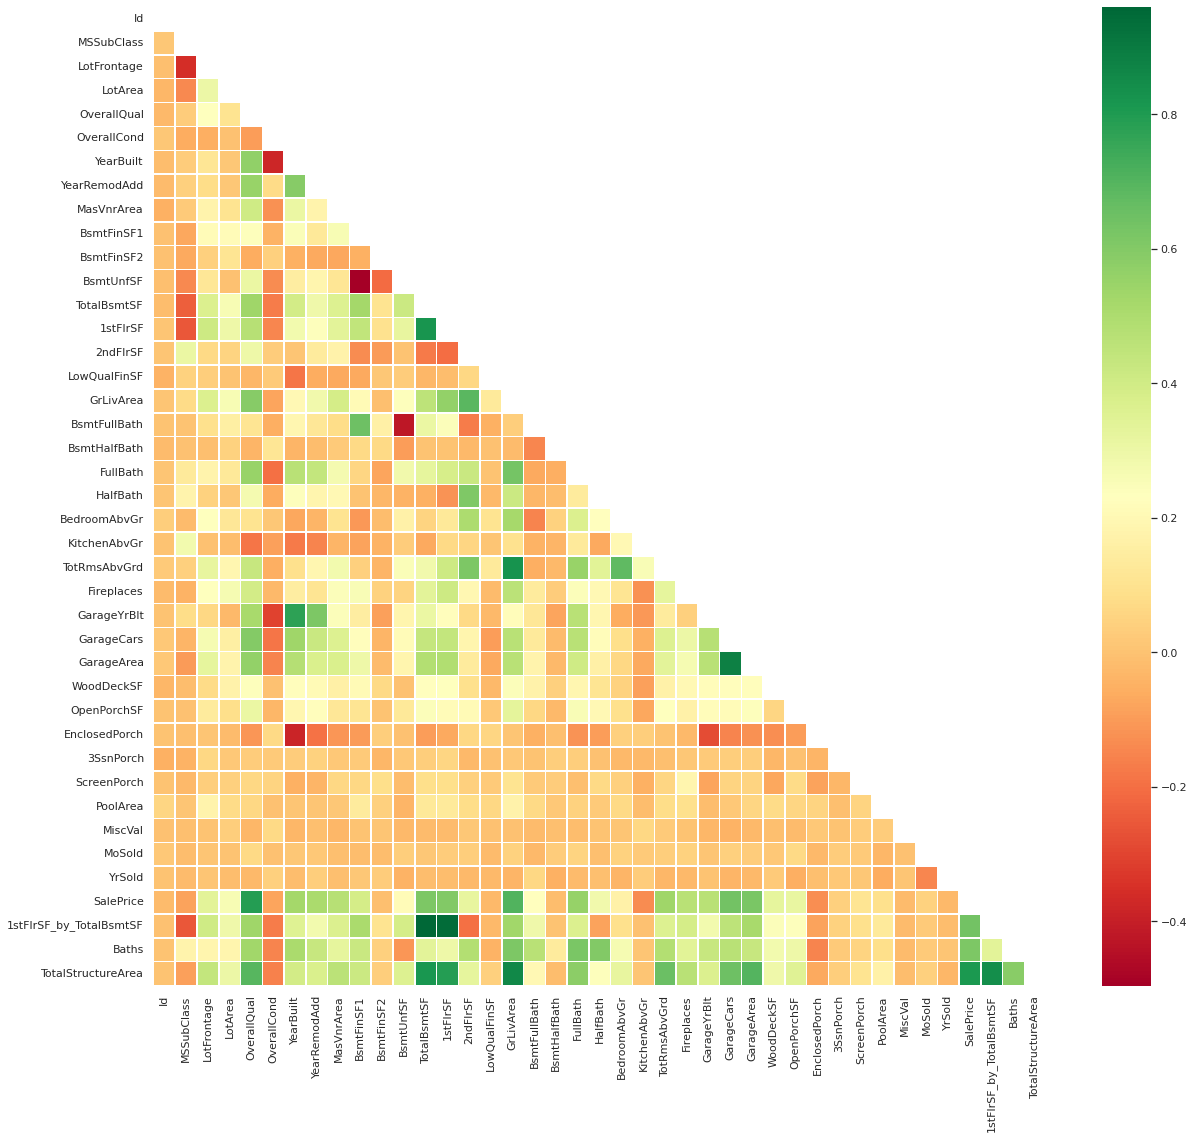

In [105]:
mask_corr_graph(train_corr, list(train_corr.columns), (20,18), show_corr=False, fig_name='all_num_corr')

In [24]:
def SF_1stFlr_Bsmt (data_frame):
  data_frame['1stFlrSF_by_TotalBsmtSF'] = data_frame['1stFlrSF'] + data_frame['TotalBsmtSF']
  return data_frame

SF_1stFlr_Bsmt(train_corr)[['1stFlrSF_by_TotalBsmtSF', '1stFlrSF','TotalBsmtSF','SalePrice']].corr()

,1stFlrSF_by_TotalBsmtSF,1stFlrSF,TotalBsmtSF,SalePrice
1stFlrSF_by_TotalBsmtSF,1.000000,0.947654,0.959601,0.639368
1stFlrSF,0.947654,1.000000,0.819530,0.605852
TotalBsmtSF,0.959601,0.819530,1.000000,0.613581
SalePrice,0.639368,0.605852,0.613581,1.000000


In [25]:
train_corr = SF_1stFlr_Bsmt(train_corr)
train = SF_1stFlr_Bsmt(train)
test = SF_1stFlr_Bsmt(test)

In [26]:
def Baths (data_frame):
  data_frame['Baths'] = data_frame['BsmtFullBath'] + data_frame['BsmtHalfBath'] + data_frame['FullBath'] + data_frame['HalfBath']
  return data_frame

Baths(train_corr)[['Baths', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','SalePrice']].corr()

,Baths,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,SalePrice
Baths,1.000000,0.468786,0.136315,0.621043,0.605905,0.613005
BsmtFullBath,0.468786,1.000000,-0.147871,-0.064512,-0.030905,0.227122
BsmtHalfBath,0.136315,-0.147871,1.000000,-0.054536,-0.012340,-0.016844
FullBath,0.621043,-0.064512,-0.054536,1.000000,0.136381,0.560664
HalfBath,0.605905,-0.030905,-0.012340,0.136381,1.000000,0.284108
SalePrice,0.613005,0.227122,-0.016844,0.560664,0.284108,1.000000


In [27]:
train_corr = Baths(train_corr)
train = Baths(train)
test = Baths(test)

In [28]:
# Create feature combining structure area of AboveGround Living Area, Garage Area, and Bsmt Area

def combined_area (data_frame):
  data_frame['TotalStructureArea'] = data_frame['GrLivArea'] + data_frame['GarageArea'] + data_frame['TotalBsmtSF']
  return data_frame

combined_area(train_corr)[['TotalStructureArea', 'GrLivArea', 'GarageArea', 'TotalBsmtSF','SalePrice']].corr()

,TotalStructureArea,GrLivArea,GarageArea,TotalBsmtSF,SalePrice
TotalStructureArea,1.000000,0.860112,0.702170,0.814750,0.807518
GrLivArea,0.860112,1.000000,0.468997,0.454868,0.708624
GarageArea,0.702170,0.468997,1.000000,0.486665,0.623431
TotalBsmtSF,0.814750,0.454868,0.486665,1.000000,0.613581
SalePrice,0.807518,0.708624,0.623431,0.613581,1.000000


In [29]:
train_corr = combined_area(train_corr)
train = combined_area(train)
test = combined_area(test)

In [30]:
print(f"train columns are: {train.columns}")
print(f"\ntest columns are: {test.columns}")

train columns are: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Garag

#### Correlations of New Features

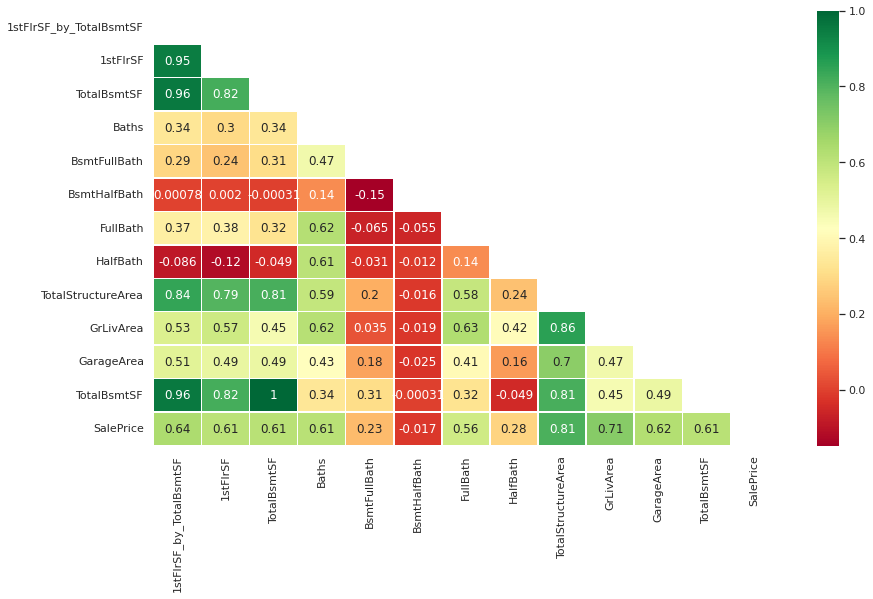

In [106]:
created_features = ['1stFlrSF_by_TotalBsmtSF', '1stFlrSF', 'TotalBsmtSF', 
                      'Baths', 'BsmtFullBath', 'BsmtHalfBath',
                      'FullBath', 'HalfBath','TotalStructureArea' , 'GrLivArea', 'GarageArea', 'TotalBsmtSF','SalePrice']
mask_corr_graph(train_corr, created_features, fig_size=(14, 8), fig_name='new_features_corr')

In [32]:
train = train.drop(columns =['1stFlrSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                      'FullBath', 'HalfBath', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'])
                   
test = test.drop(columns=['1stFlrSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                      'FullBath', 'HalfBath', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'])

### Encoding Categorical Variables

In [33]:
ordinal_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                    'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
                    'GarageQual', 'GarageCond', 'PoolQC']

In [34]:
train['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', 'No_Bsmt'], dtype=object)

In [35]:
def BsmtExposure (data_frame):
  # Modify BsmtExposure Gd which indicates Good Exposure to Ge
  # to avoid messing up the order of other variables
  data_frame['BsmtExposure'] = data_frame['BsmtExposure'].replace('Gd', 'Ge')
  return 

BsmtExposure(train)
BsmtExposure(test)

In [36]:
train['BsmtExposure'].unique()

array(['No', 'Ge', 'Mn', 'Av', 'No_Bsmt'], dtype=object)

In [37]:
[display(train[feature].value_counts())for feature in ordinal_features[:3]]

TA         649
Gd         618
Ex         121
No_Bsmt     37
Fa          35
Name: BsmtQual, dtype: int64

TA         1311
Gd           65
Fa           45
No_Bsmt      37
Po            2
Name: BsmtCond, dtype: int64

No         953
Av         221
Ge         134
Mn         114
No_Bsmt     38
Name: BsmtExposure, dtype: int64

[None, None, None]

In [38]:
def ordinal_values (data_frame, ordinal_features):
  ordinal_all = []

  for feature in ordinal_features:
    ordinal_all = ordinal_all + list(data_frame[feature].unique())

  unique_ordinal =  set(ordinal_all)
  
  return unique_ordinal

ordinal_values(train, ordinal_features)
ordinal_values(test, ordinal_features)

{'ALQ',
 'Av',
 'BLQ',
 'Ex',
 'Fa',
 'Fin',
 'GLQ',
 'Gd',
 'Ge',
 'LwQ',
 'Mn',
 'No',
 'No_Bsmt',
 'No_Fireplace',
 'No_Garage',
 'No_Kitchen',
 'No_Pool',
 'Po',
 'RFn',
 'Rec',
 'TA',
 'Unf'}

In [39]:
test[list(ordinal_features)]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC
0,TA,TA,No,Rec,LwQ,TA,TA,No_Fireplace,Unf,TA,TA,No_Pool
1,TA,TA,No,ALQ,Unf,TA,Gd,No_Fireplace,Unf,TA,TA,No_Pool
2,Gd,TA,No,GLQ,Unf,Gd,TA,TA,Fin,TA,TA,No_Pool
3,TA,TA,No,GLQ,Unf,Ex,Gd,Gd,Fin,TA,TA,No_Pool
4,Gd,TA,No,ALQ,Unf,Ex,Gd,No_Fireplace,RFn,TA,TA,No_Pool
...,...,...,...,...,...,...,...,...,...,...,...,...
1454,TA,TA,No,Unf,Unf,Gd,TA,No_Fireplace,No_Garage,No_Garage,No_Garage,No_Pool
1455,TA,TA,No,Rec,Unf,TA,TA,No_Fireplace,Unf,TA,TA,No_Pool
1456,TA,TA,No,ALQ,Unf,Ex,TA,TA,Unf,TA,TA,No_Pool
1457,Gd,TA,Av,GLQ,Unf,TA,TA,No_Fireplace,No_Garage,No_Garage,No_Garage,No_Pool


In [40]:
def change_ordinal (data_frame, ordinal_features):
  
  change_measures = {'ALQ': 5, 'Av': 3, 'BLQ': 4,  'Ex': 5, 'Fa': 2, 'Fin': 3,
  'GLQ': 6, 'Gd': 4, 'Ge': 4, 'LwQ': 2, 'Mn': 2, 'No': 1,
  'No_Bsmt': 0, 'No_Fireplace': 0, 'No_Garage': 0,
  'No_Kitchen': 0, 'No_Pool':0, 'Po': 1, 'RFn': 2,
  'Rec': 3, 'TA': 3, 'Unf': 1}

  ordinal_encoded = pd.DataFrame()
  ordinal_encoded = data_frame[list(ordinal_features)].copy()

  data_frame[ordinal_features]  = ordinal_encoded[ordinal_features].replace(change_measures)

  return

change_ordinal(train, ordinal_features)
change_ordinal(test, ordinal_features)

In [41]:
[display(train[feature].value_counts()) for feature in ordinal_features[:3]]

3    649
4    618
5    121
0     37
2     35
Name: BsmtQual, dtype: int64

3    1311
4      65
2      45
0      37
1       2
Name: BsmtCond, dtype: int64

1    953
3    221
4    134
2    114
0     38
Name: BsmtExposure, dtype: int64

[None, None, None]

In [42]:
display(train.shape)
display(test.shape)

(1460, 75)

(1459, 75)

In [43]:
def cat_num (data_frame):
  # Differentiate numerical features (minus the target) and categorical features
  # Inspired by JulienCS's script: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  categorical_features = data_frame.select_dtypes(include = ["object"]).columns
  numerical_features = data_frame.select_dtypes(exclude = ["object"]).columns
  return categorical_features, numerical_features

In [44]:
set_difference = set(list(cat_num(train)[0])) - set(ordinal_features)

remaining_features = list(set_difference)

encoded_dummies = pd.get_dummies(train[remaining_features])

train = train[list(cat_num(train)[1]) + ordinal_features]

train = pd.concat([train, encoded_dummies], axis=1)
display(train.shape)

(1460, 260)

In [45]:
display(train.shape)
display(test.shape)

(1460, 260)

(1459, 75)

In [46]:
set_difference_test = set(list(cat_num(test)[0])) - set(ordinal_features)

remaining_features_test = list(set_difference_test)

encoded_dummies_test = pd.get_dummies(test[remaining_features_test])

test = test[list(cat_num(test)[1]) + ordinal_features]

test = pd.concat([test, encoded_dummies_test], axis=1)

display(test.shape)

(1459, 249)

#### Observe Correlations of Train Data With Enocoded Variables

In [47]:
train_corr_en = pd.DataFrame()
train_corr_en = train
train_corr_en['SalePrice'] = y.copy()

train_corr_en

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,2ndFlrSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,...,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,4,3,1,6,706,1,0,150,5,854,0,3,1,4,8,0,0,2003.0,2,2,3,3,0,61,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,4,3,4,5,978,1,0,284,5,0,0,3,1,3,6,1,3,1976.0,2,2,3,3,298,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,4,3,2,6,486,1,0,434,5,866,0,3,1,4,6,1,3,2001.0,2,2,3,3,0,42,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,3,4,1,5,216,1,0,540,4,756,0,3,1,4,7,1,4,1998.0,1,3,3,3,0,35,272,0,0,0,0,0,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,4,3,3,6,655,1,0,490,5,1053,0,4,1,4,9,1,3,2000.0,2,3,3,3,192,84,0,0,0,0,0,0,12,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,4,3,1,1,0,1,0,953,5,694,0,3,1,3,7,1,3,1999.0,2,2,3,3,0,40,0,0,0,0,0,0,8,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,4,3,1,5,790,3,163,589,3,0,0,3,1,3,7,2,3,1978.0,1,2,3,3,349,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,3,4,1,6,275,1,0,877,5,1152,0,4,1,4,9,2,4,1941.0,2,1,3,3,0,60,0,0,0,0,0,2500,5,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,3,3,2,6,49,3,1029,0,4,0,0,2,1,4,5,0,0,1950.0,1,1,3,3,366,0,112,0,0,0,0,0,4,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,142125


In [48]:
dependent_corr = train.corr()['SalePrice'].drop(labels=['Id', 'SalePrice'])

corr_stats = dependent_corr.describe()

# Create list of top 25% and bottom 25% of correlations with Sale Price
dependent_corr_quarters = dependent_corr[(dependent_corr >= corr_stats[6]) 
                    | (dependent_corr <= corr_stats[4])]
                    
corr_quarters = pd.DataFrame(dependent_corr_quarters.sort_values(ascending=False))


In [49]:
dependent_corr

MSSubClass        -0.084284
LotFrontage        0.334771
LotArea            0.263843
OverallQual        0.790982
OverallCond       -0.077856
                     ...   
Condition2_PosA    0.047497
Condition2_PosN    0.048481
Condition2_RRAe    0.002993
Condition2_RRAn   -0.014510
Condition2_RRNn   -0.039255
Name: SalePrice, Length: 259, dtype: float64

In [50]:
train_top = dependent_corr[(dependent_corr >= 0.5) | (dependent_corr <= -0.5)]
top_correlated = list(train_top.index)

In [51]:
train_top.sort_values(ascending=False)

TotalStructureArea         0.807518
OverallQual                0.790982
KitchenQual                0.659600
KitchenQual                0.659600
GarageCars                 0.640409
1stFlrSF_by_TotalBsmtSF    0.639368
Baths                      0.613005
BsmtQual                   0.585207
BsmtQual                   0.585207
GarageFinish               0.549247
GarageFinish               0.549247
TotRmsAbvGrd               0.533723
YearBuilt                  0.522897
FireplaceQu                0.520438
FireplaceQu                0.520438
YearRemodAdd               0.507101
ExterQual_TA              -0.589044
Name: SalePrice, dtype: float64

In [52]:
top_correlated

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtQual',
 'KitchenQual',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 '1stFlrSF_by_TotalBsmtSF',
 'Baths',
 'TotalStructureArea',
 'BsmtQual',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'ExterQual_TA']

### Evaluating Features Highly Correlated Features

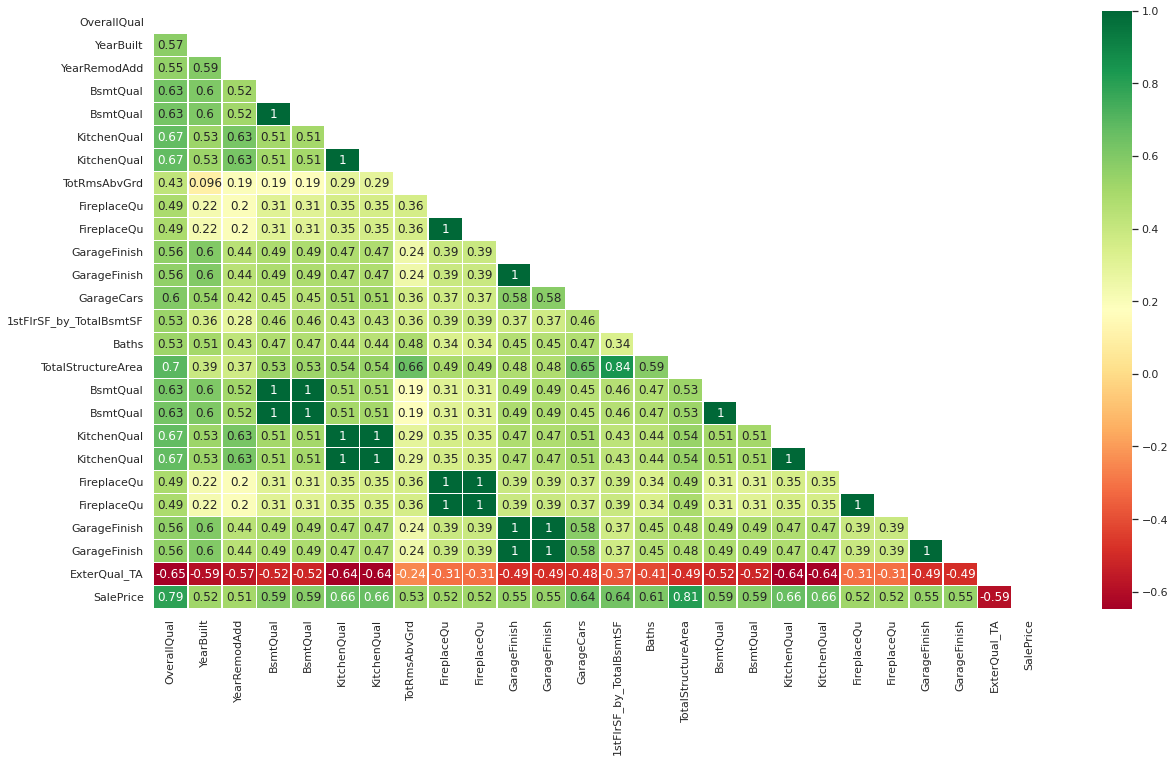

In [107]:
mask_corr_graph(train_corr_en, top_correlated + ['SalePrice'], fig_size=(20, 11), fig_name='highly_correlated_feat_corr')

## Modeling

In [54]:
train = train[top_correlated]
print(train.shape)

id_test = test['Id']
test = test[top_correlated]
print(test.shape)

(1460, 25)
(1459, 25)


In [55]:
# Create training and test sets of preprocessed train data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=10)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 25)
X_test : (438, 25)
y_train : (1022,)
y_test : (438,)


### Scaling

In [56]:
scaler = StandardScaler()

X_train_std  = scaler.fit_transform(X_train.values)
X_test_std = scaler.fit_transform(X_test.values)
testing_std  = scaler.fit_transform(test.values)


mm_scaler = MinMaxScaler()

X_train_mm = mm_scaler.fit_transform(X_train.values)
X_test_mm = mm_scaler.fit_transform(X_test.values)
testing_mm  = mm_scaler.fit_transform(test.values)


rb_scaler = RobustScaler()
X_train_rb = rb_scaler.fit_transform(X_train.values)
X_test_rb = rb_scaler.fit_transform(X_test.values)
testing_rb = rb_scaler.fit_transform(test.values)


#### Model Evaluation

In [57]:
# Differentiate numerical features (minus the target) and categorical features
# Inspired by JulienCS's script: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

def evaluating_model (y_true, y_pred):
  print(f"MSE: {mean_squared_error(y_true, y_pred)}")
  print(f"RMSE: {mean_squared_error(y_true, y_pred)**0.5}")
  print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
  print(f"R_SQR: {r2_score(y_true, y_pred)}")
  print(f"EXV: {explained_variance_score(y_true, y_pred)}")
  print(f"ME: {max_error(y_true, y_pred)}")
  print(f"RMSLE: {mean_squared_log_error(y_true, y_pred)**0.5}")
  return

### Linear Regression

In [58]:
lr = LinearRegression()


In [64]:
# Use standard scaler with linear regression to observe how train data predictions work
lr.fit(X_train_std, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_std = lr.predict(X_train_std)
y_test_pred_std = lr.predict(X_test_std)

evaluating_model(y_train, y_train_pred_std)

RMSE on Training set : 39319.99831913451
RMSE on Test set : 31768.08099678278
MSE: 1462060278.4883692
RMSE: 38236.896820850525
MAE: 23960.742893919203
R_SQR: 0.7748780460382476
EXV: 0.7748780460382476
ME: 429050.1513431842
RMSLE: 0.19944954369422296


In [65]:
evaluating_model(y_test, y_test_pred_std)

MSE: 1080819014.2844834
RMSE: 32875.81199429884
MAE: 23566.870799001903
R_SQR: 0.8155102038302122
EXV: 0.8180252797523986
ME: 235262.7355625591


ValueError: ignored

In [60]:
# Use minmax scaler with linear regression to observe  how train data predictions work
lr.fit(X_train_mm, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_mm = lr.predict(X_train_mm)
y_test_pred_mm = lr.predict(X_test_mm)

evaluating_model(y_train, y_train_pred_mm)

RMSE on Training set : 39319.99831913451
RMSE on Test set : 31768.08099678278
MSE: 1462060278.488369
RMSE: 38236.896820850525
MAE: 23960.742893919174
R_SQR: 0.7748780460382476
EXV: 0.7748780460382476
ME: 429050.15134318336
RMSLE: 0.1994495436942223


In [66]:
evaluating_model(y_test, y_test_pred_mm)

MSE: 13627428144.129967
RMSE: 116736.57586262314
MAE: 110567.98099551894
R_SQR: -1.3261262129935312
EXV: 0.7359597353471063
ME: 223134.17800805997


ValueError: ignored

In [67]:
# Use robust scaler with linear regression to observe how train data predictions work
lr.fit(X_train_rb, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_rb = lr.predict(X_train_rb)
y_test_pred_rb = lr.predict(X_test_rb)

evaluating_model(y_train, y_train_pred_rb)

RMSE on Training set : 39319.99831913451
RMSE on Test set : 31768.08099678278
MSE: 1462060278.4883692
RMSE: 38236.896820850525
MAE: 23960.74289391918
R_SQR: 0.7748780460382476
EXV: 0.7748780460382476
ME: 429050.1513431838
RMSLE: 0.19944954369422224


In [68]:
evaluating_model(y_test, y_test_pred_rb)

MSE: 1076682269.7912276
RMSE: 32812.83696651705
MAE: 23596.948009195945
R_SQR: 0.8162163231140893
EXV: 0.8172390135879567
ME: 234437.5659908487


ValueError: ignored

In [69]:
lr = LinearRegression()

In [96]:
# Use standard scaler and linear regression to predict test sale price data
lr.fit(X_train_std, y_train.values)

y_test_pred = lr.predict(testing_std)

pred_test_std_lr = pd.DataFrame()

pred_test_std_lr['Id'] = id_test
pred_test_std_lr['SalePrice'] = y_test_pred
pred_test_std_lr.to_csv('std_lr_houseprice_25_agg_1_23.csv', index=False)

In [71]:
# Use minmax scaler and linear regression to predict test sale price data
lr.fit(X_train_mm, y_train.values)

y_test_pred = lr.predict(testing_mm)

pred_test_mm_lr = pd.DataFrame()

pred_test_mm_lr['Id'] = id_test
pred_test_mm_lr['SalePrice'] = y_test_pred
# pred_test_mm_lr.to_csv('mm_lr_houseprice_10_1_20.csv', index=False)

In [72]:
# Use minmax scaler and linear regression to predict test sale price data
lr.fit(X_train_rb, y_train.values)

y_test_pred = lr.predict(testing_rb)

pred_test_rb_lr = pd.DataFrame()

pred_test_rb_lr['Id'] = id_test
pred_test_rb_lr['SalePrice'] = y_test_pred
# pred_test_rb_lr.to_csv('rb_lr_houseprice_10_1_20.csv', index=False)

### Ridge

In [73]:
rd = Ridge()

In [74]:
rd.fit(X_train_std, y_train.values)

print("RMSE on Training set :", rmse_cv_train(rd).mean())
print("RMSE on Test set :", rmse_cv_test(rd).mean())

y_train_pred_std = rd.predict(X_train_std)
y_test_pred_std = rd.predict(X_test_std)

evaluating_model(y_train, y_train_pred_std)

RMSE on Training set : 39317.13406752598
RMSE on Test set : 31759.63667823058
MSE: 1462067621.5450335
RMSE: 38236.99284129223
MAE: 23961.13484153644
R_SQR: 0.7748769153849574
EXV: 0.7748769153849574
ME: 428308.24837785447
RMSLE: 0.19940879424072347


In [75]:
evaluating_model(y_test, y_test_pred_std)

MSE: 1080429531.390617
RMSE: 32869.887912656726
MAE: 23563.959549745417
R_SQR: 0.8155766863945929
EXV: 0.8180917623167793
ME: 235089.73324271577


ValueError: ignored

In [97]:
rd.fit(X_train_std, y_train.values)

y_test_pred = rd.predict(testing_std)

pred_test_std_rd = pd.DataFrame()

pred_test_std_rd['Id'] = id_test
pred_test_std_rd['SalePrice'] = y_test_pred
pred_test_std_rd.to_csv('std_rd_houseprice_25_agg_1_23.csv', index=False)

### Lasso

In [77]:
lasso = Lasso(max_iter=3000, tol=.01)

In [78]:
lasso.fit(X_train_std, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lasso).mean())
print("RMSE on Test set :", rmse_cv_test(lasso).mean())

y_train_pred_std = lasso.predict(X_train_std)
y_test_pred_std = lasso.predict(X_test_std)

evaluating_model(y_train, y_train_pred_std)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.741e+11, tolerance: 5.685e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.343e+11, tolerance: 5.681e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

RMSE on Training set : 39319.3193186232


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e+11, tolerance: 2.282e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+11, tolerance: 2.008e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

RMSE on Test set : 31767.97865949735
MSE: 1462060303.950887
RMSE: 38236.89715380796
MAE: 23960.65053482874
R_SQR: 0.7748780421176351
EXV: 0.7748780421176351
ME: 429028.4078923771
RMSLE: 0.19945167180227077


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e+11, tolerance: 2.246e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e+11, tolerance: 2.394e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

In [98]:
lasso.fit(X_train_std, y_train.values)

y_test_pred = lasso.predict(testing_std)

pred_test_std_lasso = pd.DataFrame()

pred_test_std_lasso['Id'] = id_test
pred_test_std_lasso['SalePrice'] = y_test_pred
pred_test_std_lasso.to_csv('std_lasso_houseprice_25_agg_1_23.csv', index=False)

### ElasticNet

In [91]:
en = ElasticNet(max_iter=2000, tol=0.0001)

In [99]:
en.fit(X_train_std, y_train.values)

print("RMSE on Training set :", rmse_cv_train(en).mean())
print("RMSE on Test set :", rmse_cv_test(en).mean())

y_train_pred_std = en.predict(X_train_std)
y_test_pred_std = en.predict(X_test_std)

evaluating_model(y_train, y_train_pred_std)

RMSE on Training set : 39504.06620237653
RMSE on Test set : 31762.049018402497
MSE: 1550347202.0230284
RMSE: 39374.44859325688
MAE: 24447.95608780009
R_SQR: 0.7612839931610684
EXV: 0.7612839931610684
ME: 355706.9095511534
RMSLE: 0.19123981255614023


In [100]:
en.fit(X_train_mm, y_train.values)

print("RMSE on Training set :", rmse_cv_train(en).mean())
print("RMSE on Test set :", rmse_cv_test(en).mean())

y_train_pred_mm = en.predict(X_train_mm)
y_test_pred_mm = en.predict(X_test_mm)

evaluating_model(y_train, y_train_pred_mm)

RMSE on Training set : 39504.06620237653
RMSE on Test set : 31762.049018402497
MSE: 2913703865.3509765
RMSE: 53978.735307072326
MAE: 33976.30611187507
R_SQR: 0.5513600108800571
EXV: 0.5513600108800571
ME: 482292.98731225415
RMSLE: 0.24664924855885847


In [101]:
en.fit(X_train_mm, y_train.values)

y_test_pred = en.predict(testing_mm)

pred_test_mm_en = pd.DataFrame()

pred_test_mm_en['Id'] = id_test
pred_test_mm_en['SalePrice'] = y_test_pred
pred_test_mm_en.to_csv('mm_en_houseprice_25_agg_1_23.csv', index=False)

In [102]:
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X_train_std, y_train)
regr.get_params()

print("RMSE on Training set :", rmse_cv_train(regr).mean())
print("RMSE on Test set :", rmse_cv_test(regr).mean())

y_train_pred_std = regr.predict(X_train_std)
y_test_pred_std = regr.predict(X_test_std)

evaluating_model(y_train, y_train_pred_std)
evaluating_model(y_test, y_test_pred_std)

pred_test_std_encv = pd.DataFrame()

pred_test_std_encv['Id'] = id_test
pred_test_std_encv['SalePrice'] = regr.predict(testing_std)
pred_test_std_encv.to_csv('std_encv_houseprice_25_agg_1_23.csv', index=False)

RMSE on Training set : 48601.88419579556
RMSE on Test set : 40708.07919400117
MSE: 5118191571.185075
RMSE: 71541.53738343253
MAE: 50072.79904853943
R_SQR: 0.2119221729715287
EXV: 0.2119221729715287
ME: 541657.0924327743
RMSLE: 0.3521422414717557
MSE: 4527154241.411853
RMSE: 67284.13068036067
MAE: 49749.179795249496
R_SQR: 0.22723994286852423
EXV: 0.2297550187907107
ME: 400613.33246328286
RMSLE: 0.3696249011501233


## Conclusion

This home sale prices model could be helpful for listing agents deciding at what price to first list a house depending on a variety of home factors. Similarly, this model could help consumers on the otherside of the deal to determine if the sale price is appropriate. Cities or municipalities may also be interested in better determing home sale price in order to best determine property taxes to levy. 

The following features were used as predictors for home sale prices: 
* OverallQual
* YearBuilt
* YearRemodAdd
* BsmtQual
* KitchenQual
* TotRmsAbvGrd
* FireplaceQu
* GarageFinish
* GarageCars
* 1stFlrSF_by_TotalBsmtSF
* Baths
* TotalStructureArea
* BsmtQual
* KitchenQual
* FireplaceQu
* GarageFinish
* ExterQual_TA

The following regression models were used: linear, ridge, lasso and elastic net in combinationg with either standard or minmax scaling. Although the RMSE for the train data went down compared to previous models, all of the models are likely overfitting to the training data. I had errors when I tried to compute th RMSE for the y_test. 

![standard_linear_reg]
